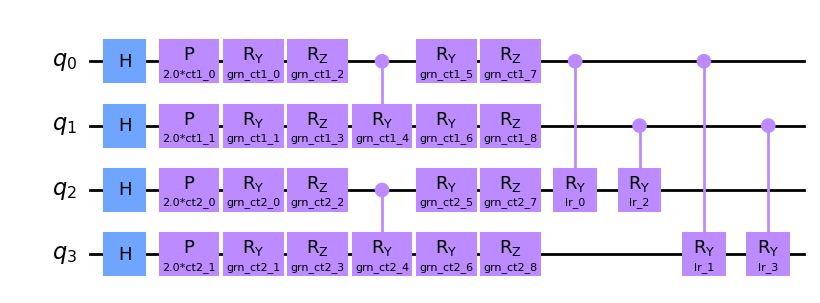

In [91]:
from qiskit.circuit.library import ZFeatureMap, TwoLocal
from qiskit.circuit import QuantumCircuit, Parameter

ng_ct1 = 2
ng_ct2 = 2
num_features = ng_ct1 + ng_ct2

# Separate feature maps
feature_map_ct1 = ZFeatureMap(feature_dimension=ng_ct1, reps=1, name="feature_ct1")
feature_map_ct2 = ZFeatureMap(feature_dimension=ng_ct2, reps=1, name="feature_ct2")

# TwoLocal ansatzes (within cell types)
ansatz_grn_ct1 = TwoLocal(num_qubits=ng_ct1, rotation_blocks=['ry', 'rz'], entanglement_blocks='cry', entanglement='full', reps=1, name="ansatz_grn_ct1")
ansatz_grn_ct2 = TwoLocal(num_qubits=ng_ct2, rotation_blocks=['ry', 'rz'], entanglement_blocks='cry', entanglement='full', reps=1, name="ansatz_grn_ct2")

# Ligand-receptor interaction ansatz (across cell types)
def generate_inter_cell_pairs(ng_ct1, ng_ct2, direction="forward"):
    """Generates pairs of qubits for inter-cell interactions.
    Args:
        ng_ct1: Number of qubits in cell type 1.
        ng_ct2: Number of qubits in cell type 2.
        direction: "forward" for interactions from ct1 to ct2,
                   "backward" for interactions from ct2 to ct1,
    Returns:
        A list of qubit pairs.
    """
    pairs = []
    if direction == "forward":
        for i in range(ng_ct1):
            for j in range(ng_ct2):
                pairs.append([i, j + ng_ct1])
    elif direction == "backward":
        for i in range(ng_ct2):
            for j in range(ng_ct1):
                pairs.append([j + ng_ct2, i])

    else:
        raise ValueError("Invalid direction. Must be 'forward' or 'backward''.")
    return pairs

lr_entanglement = generate_inter_cell_pairs(ng_ct1, ng_ct2, direction="forward")  # Example: Entangle corresponding genes
#lr_entanglement = [[0, 2], [3, 1]]  # Example: Entangle corresponding genes

ansatz_lr = TwoLocal(num_qubits=num_features, entanglement_blocks='cry', entanglement=lr_entanglement, reps=1, name="ansatz_lr")  # One ansatz for all

# Parameter binding for the ansatzes (Do this FIRST)
theta_ct1 = [Parameter(f"ct1_{i}") for i in range(feature_map_ct1.num_parameters)]
theta_ct2 = [Parameter(f"ct2_{i}") for i in range(feature_map_ct2.num_parameters)]
theta_grn_ct1 = [Parameter(f"grn_ct1_{i}") for i in range(ansatz_grn_ct1.num_parameters)]
theta_grn_ct2 = [Parameter(f"grn_ct2_{i}") for i in range(ansatz_grn_ct2.num_parameters)]
theta_lr = [Parameter(f"lr_{i}") for i in range(ansatz_lr.num_parameters)]

param_dict_ct1 = dict(zip(feature_map_ct1.parameters, theta_ct1))
param_dict_ct2 = dict(zip(feature_map_ct2.parameters, theta_ct2))
param_dict_grn_ct1 = dict(zip(ansatz_grn_ct1.parameters, theta_grn_ct1))
param_dict_grn_ct2 = dict(zip(ansatz_grn_ct2.parameters, theta_grn_ct2))
param_dict_lr = dict(zip(ansatz_lr.parameters, theta_lr))

feature_map_ct1.assign_parameters(param_dict_ct1, inplace=True)
feature_map_ct2.assign_parameters(param_dict_ct2, inplace=True)
ansatz_grn_ct1.assign_parameters(param_dict_grn_ct1, inplace=True)
ansatz_grn_ct2.assign_parameters(param_dict_grn_ct2, inplace=True)
ansatz_lr.assign_parameters(param_dict_lr, inplace=True)

# Decompose feature maps and ansatzes before appending them
feature_map_ct1_decomposed = feature_map_ct1.decompose()
feature_map_ct2_decomposed = feature_map_ct2.decompose()
ansatz_grn_ct1_decomposed = ansatz_grn_ct1.decompose()
ansatz_grn_ct2_decomposed = ansatz_grn_ct2.decompose()
ansatz_lr_decomposed = ansatz_lr.decompose()

# Combine everything into the final circuit
ccgrn_circuit = QuantumCircuit(num_features, name="ccgrn_network")
# Add decomposed feature maps
ccgrn_circuit.append(feature_map_ct1_decomposed, [0, 1])
ccgrn_circuit.append(feature_map_ct2_decomposed, [2, 3])
# Add the decomposed cell-specific ansatzes
ccgrn_circuit.append(ansatz_grn_ct1_decomposed, [0, 1])
ccgrn_circuit.append(ansatz_grn_ct2_decomposed, [2, 3])
# Add decomposed LR interaction ansatz
ccgrn_circuit.append(ansatz_lr_decomposed, range(num_features))

# Now you should see the individual gates when you draw the circuit
ccgrn_circuit.decompose().draw(output="mpl", style="clifford", fold=40)


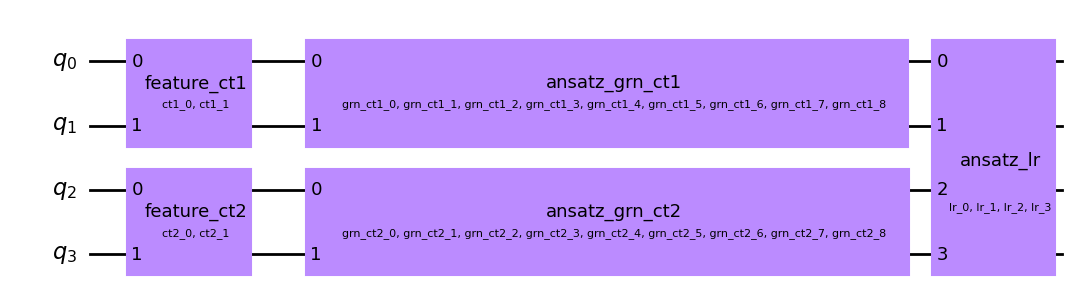

In [92]:
# Now you should see the individual gates when you draw the circuit
ccgrn_circuit.draw(output="mpl", style="clifford", fold=40)

In [93]:
# Define cost function ONCE (outside the optimization loop)
def cost_func_vqe(params, combined_ansatz, hamiltonian, estimator):
    """Cost function for VQE (using StatevectorEstimator)"""
    bound_ansatz = combined_ansatz.assign_parameters(params)
    statevector = Statevector(bound_ansatz)  # Get the statevector
    statevector_array = statevector.data  # Convert Statevector to NumPy array

    # Correct way to calculate expectation value:
    hamiltonian_matrix = hamiltonian.to_matrix()
    energy = np.real(statevector_array.conjugate() @ hamiltonian_matrix @ statevector_array)  # Use @ operator
    
    #cost = estimator.run([pub]).result()[0].data.evs
    # or
    # energy = np.real(np.dot(statevector_array.conjugate(), np.dot(hamiltonian_matrix, statevector_array))) #Use numpy.dot

    return energy

In [94]:
from qiskit.circuit.library import ZFeatureMap, TwoLocal
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.primitives import StatevectorEstimator
from qiskit_ibm_runtime import EstimatorV2 as Estimator
import numpy as np
from scipy.optimize import minimize

# Initialize estimator ONCE (outside the optimization loop)
estimator = StatevectorEstimator()
#estimator = Estimator()

# --- Interaction Strength (Generalized) ---
interaction_strength_list = []
for pair in lr_entanglement:
    qubit1, qubit2 = pair
    pauli_string = ""
    for i in range(num_features):  # Assuming 4 qubits total (adjust if needed)
        if i == qubit1 or i == qubit2:
            pauli_string += "Z"  # Or "X" or "Y" for different interaction types
        else:
            pauli_string += "I"
    interaction_strength_list.append((pauli_string, -1.0))  # -1.0 or other strength

interaction_strength = SparsePauliOp.from_list(interaction_strength_list)
print(interaction_strength)  # Should see the interaction strength
#interaction_strength = SparsePauliOp.from_list([("ZZII", -1.0), ("IIZZ", -1.0)])  # Example

x0_interaction = np.random.rand(ccgrn_circuit.num_parameters)

result_interaction_bfgs = minimize(
    cost_func_vqe, 
    x0_interaction, 
    args=(ccgrn_circuit, interaction_strength, estimator), 
    method="BFGS"
)
print("BFGS (Interaction Strength):", result_interaction_bfgs)

SparsePauliOp(['ZIZI', 'ZIIZ', 'IZZI', 'IZIZ'],
              coeffs=[-1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j])
BFGS (Interaction Strength):   message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -3.999999999997515
        x: [ 3.252e-02 -1.849e-01 ...  2.707e+00 -3.027e+00]
      nit: 24
      jac: [-3.010e-06 -1.281e-06 ... -1.162e-06  8.941e-07]
 hess_inv: [[ 1.994e-01 -2.193e-03 ... -1.639e-02  2.755e-02]
            [-2.193e-03  2.602e-01 ... -3.428e-02  1.795e-02]
            ...
            [-1.639e-02 -3.428e-02 ...  7.486e-01 -7.970e-02]
            [ 2.755e-02  1.795e-02 ... -7.970e-02  8.498e-01]]
     nfev: 918
     njev: 34


In [95]:
import pandas as pd
from scipy.optimize import minimize

imized_parameters = result_interaction_bfgs.x
parameters = ccgrn_circuit.parameters  # Get the ParameterView

# Directly create the dictionary for bind_parameters
param_dict = dict(zip(parameters, optimized_parameters))

# Convert to pandas DataFrame (if you still need it for printing/analysis)
df = pd.DataFrame(list(param_dict.items()), columns=['Parameter', 'Value'])

df_nonzero = df[df.Value >= 0.01]
df_nonzero


,Parameter,Value
0,ct1_0,1.364072
2,ct2_0,1.259047
3,ct2_1,0.550292
4,grn_ct1_0,0.935824
5,grn_ct1_1,0.740284
6,grn_ct1_2,0.038989
7,grn_ct1_3,0.209655
9,grn_ct1_5,0.077329
10,grn_ct1_6,0.841518
11,grn_ct1_7,0.650421


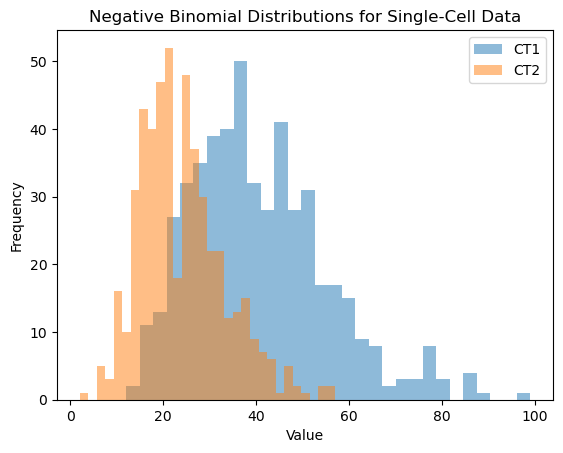

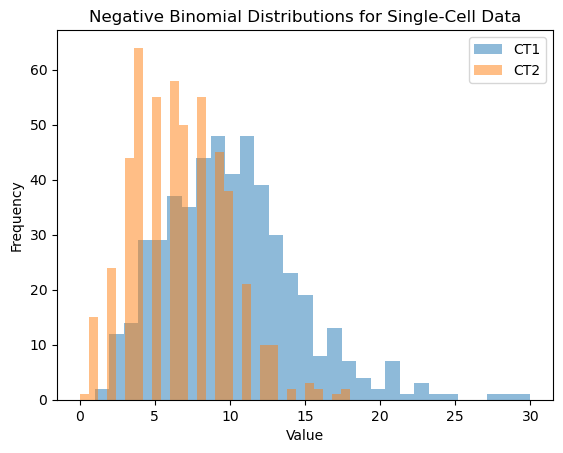

ct1_data matrix (2xN):
 (2, 500)
ct2_data matrix (2xN):
 (2, 500)


In [6]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_gene_distribution(prob1, prob2, size=10, num_cells=500, seed=42, save_data=False, print_data=False, plotit=False):
    # Set a random seed for reproducibility
    np.random.seed(seed)
    
    # Generate negative binomial data for two cell types
    ct1_data = np.random.negative_binomial(size, prob1, num_cells)
    ct2_data = np.random.negative_binomial(size, prob2, num_cells)
    
    # Optionally print the data
    if print_data:
        print("CT1 Data:", ct1_data)
        print("CT2 Data:", ct2_data)
    
    # Save the data if requested
    if save_data:
        np.savetxt('ct1_data.csv', ct1_data, delimiter=',')
        np.savetxt('ct2_data.csv', ct2_data, delimiter=',')
        print("Data saved as 'ct1_data.csv' and 'ct2_data.csv'")
    
    if plotit:
        # Create histograms for both distributions
        plt.hist(ct1_data, bins=30, alpha=0.5, label='CT1')
        plt.hist(ct2_data, bins=30, alpha=0.5, label='CT2')
    
        # Add labels and title
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.title('Negative Binomial Distributions for Single-Cell Data')
    
        # Add legend
        plt.legend(loc='upper right')
    
        # Show the plot
        plt.show()

    # Return the data for further use if needed
    return ct1_data, ct2_data

# Example of using the function
ct1_data_g1, ct2_data_g1 = simulate_gene_distribution(0.2, 0.3, save_data=False, print_data=False, plotit=True)
ct1_data_g2, ct2_data_g2 = simulate_gene_distribution(0.5, 0.6, save_data=False, print_data=False, plotit=True)

# Create 2xN matrix where N is the number of cells
ct1_data = np.vstack([ct1_data_g1, ct1_data_g2])  # Stack along the rows (2xN for ct1)
ct2_data = np.vstack([ct2_data_g1, ct2_data_g2])  # Stack along the rows (2xN for ct2)

# Display the resulting matrices
print("ct1_data matrix (2xN):\n", ct1_data.shape)
print("ct2_data matrix (2xN):\n", ct2_data.shape)


In [7]:
import numpy as np

def min_max_scale(data):
    """
    Min-max scale the input data to the range [-π/2, π/2] by row (gene).

    Args:
        data (numpy array): The data to be scaled (rows are genes, columns are cells).

    Returns:
        numpy array: The scaled data in the range [-π/2, π/2], scaled row-wise.
    """
    # Initialize a new array to store the scaled data
    scaled_data = np.empty_like(data, dtype=float)

    # Apply min-max scaling to each row (gene) individually
    for i in range(data.shape[0]):  # Iterate over rows (genes)
        min_value = np.min(data[i])
        max_value = np.max(data[i])
        
        # Perform min-max scaling to the range [-π/2, π/2]
        scaled_data[i] = ((data[i] - min_value) / (max_value - min_value)) * (np.pi / 2 - (-np.pi / 2)) - (np.pi / 2)
    
    return scaled_data

# Apply scaling to each gene (row) for both cell types
ct1_data_scaled = min_max_scale(ct1_data)  # Scale each gene (row) for ct1_data
ct2_data_scaled = min_max_scale(ct2_data)  # Scale each gene (row) for ct2_data

# Display the resulting scaled data
print("Scaled ct1_data:\n", ct1_data_scaled)
print("Scaled ct2_data:\n", ct2_data_scaled)
print("Scaled shape ct1_data:\n", ct1_data_scaled.shape)
print("Scaled shape ct2_data:\n", ct2_data_scaled.shape)

Scaled ct1_data:
 [[-0.30693721 -0.5958193  -1.02914242 -0.41526799 -1.10136294 -0.70415008
  -1.06525268 -0.70415008 -0.84859112  0.16249617 -0.16249617 -1.57079633
  -0.81248086 -0.88470138 -0.70415008 -0.63192956 -0.88470138 -0.88470138
  -0.23471669  0.30693721 -0.66803982  0.05416539 -0.52359878 -0.5958193
  -0.41526799 -0.5958193  -0.52359878 -1.20969372 -0.88470138 -0.41526799
  -1.3180245  -0.27082695 -0.81248086 -1.20969372  0.16249617 -1.24580398
  -0.7763706  -0.70415008 -0.66803982 -0.52359878 -1.1374732  -0.37915773
  -0.88470138 -0.37915773 -0.74026034 -0.81248086 -0.84859112 -0.09027565
  -0.7763706  -0.74026034 -0.5958193   1.1374732  -0.30693721 -0.41526799
  -0.7763706  -0.12638591 -0.41526799 -1.1374732   0.01805513 -0.12638591
  -0.27082695 -0.23471669  0.7763706  -1.10136294 -0.7763706  -1.02914242
  -1.46246555 -0.27082695 -1.20969372 -0.66803982  0.34304747 -0.70415008
  -0.7763706  -0.52359878 -0.41526799 -1.17358346 -0.92081164  0.09027565
   0.27082695 -1.2819

In [122]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit.library import ZFeatureMap, TwoLocal
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.primitives import StatevectorEstimator  # Or Estimator if using IBM Runtime
import pandas as pd
from scipy.optimize import minimize

# --- 1. Simulate and Scale Data ---
def simulate_gene_distribution(prob1, prob2, size=10, num_cells=500, seed=42):
    np.random.seed(seed)
    ct1_data = np.random.negative_binomial(size, prob1, num_cells)
    ct2_data = np.random.negative_binomial(size, prob2, num_cells)
    return ct1_data, ct2_data

ct1_data_g1, ct2_data_g1 = simulate_gene_distribution(0.8 , 0.7)
ct1_data_g2, ct2_data_g2 = simulate_gene_distribution(0.9, 0.8)

ct1_data = np.vstack([ct1_data_g1, ct1_data_g2])
ct2_data = np.vstack([ct2_data_g1, ct2_data_g2])


def calculate_cell_percentage(data):
    """Calculates the percentage of cells containing a gene (value > 0).

    Args:
        data: A NumPy array representing gene expression data.

    Returns:
        A NumPy array containing the cell percentages for each gene.
    """
    num_genes = data.shape[0]  # Number of rows (genes)
    num_cells = data.shape[1] # Number of columns (cells)
    percentages = np.zeros(num_genes)  # Initialize an array to store percentages

    for i in range(num_genes):
        positive_cells = np.sum(data[i, :] > 0)  # Count positive cells for gene i
        percentages[i] = positive_cells / num_cells

    return percentages


# Example usage (assuming ct1_data and ct2_data are your data arrays):
ct1_percentages = calculate_cell_percentage(ct1_data)
ct2_percentages = calculate_cell_percentage(ct2_data)

print("CT1 Percentages:", ct1_percentages)
print("CT2 Percentages:", ct2_percentages)

# --- 2. Quantum Circuit Setup ---
ng_ct1 = 2
ng_ct2 = 2
num_features = ng_ct1 + ng_ct2

feature_map_ct1 = ZFeatureMap(feature_dimension=ng_ct1, reps=1)
feature_map_ct2 = ZFeatureMap(feature_dimension=ng_ct2, reps=1)

ansatz_grn_ct1 = TwoLocal(num_qubits=ng_ct1, rotation_blocks=['ry', 'rz'], entanglement_blocks='cry', entanglement='full', reps=2)
ansatz_grn_ct2 = TwoLocal(num_qubits=ng_ct2, rotation_blocks=['ry', 'rz'], entanglement_blocks='cry', entanglement='full', reps=2)

# Ligand-receptor interaction ansatz (across cell types)
def generate_inter_cell_pairs(ng_ct1, ng_ct2, direction="forward"):
    """Generates pairs of qubits for inter-cell interactions.
    Args:
        ng_ct1: Number of qubits in cell type 1.
        ng_ct2: Number of qubits in cell type 2.
        direction: "forward" for interactions from ct1 to ct2,
                   "backward" for interactions from ct2 to ct1,
    Returns:
        A list of qubit pairs.
    """
    pairs = []
    if direction == "forward":
        for i in range(ng_ct1):
            for j in range(ng_ct2):
                pairs.append([i, j + ng_ct1])
    elif direction == "backward":
        for i in range(ng_ct2):
            for j in range(ng_ct1):
                pairs.append([j + ng_ct2, i])

    else:
        raise ValueError("Invalid direction. Must be 'forward' or 'backward''.")
    return pairs

lr_entanglement = generate_inter_cell_pairs(ng_ct1, ng_ct2, direction="forward")  # Example: Entangle corresponding genes
#lr_entanglement = [[0, 2], [3, 1]]  # Example: Entangle corresponding genes
ansatz_lr = TwoLocal(num_qubits=num_features, entanglement_blocks='cry', entanglement=lr_entanglement, reps=1)

# Parameter Binding (Important!)
theta_ct1 = [Parameter(f"ct1_{i}") for i in range(feature_map_ct1.num_parameters)]
theta_ct2 = [Parameter(f"ct2_{i}") for i in range(feature_map_ct2.num_parameters)]
theta_grn_ct1 = [Parameter(f"grn_ct1_{i}") for i in range(ansatz_grn_ct1.num_parameters)]
theta_grn_ct2 = [Parameter(f"grn_ct2_{i}") for i in range(ansatz_grn_ct2.num_parameters)]
theta_lr = [Parameter(f"lr_{i}") for i in range(ansatz_lr.num_parameters)]

param_dict_ct1 = dict(zip(feature_map_ct1.parameters, theta_ct1))
param_dict_ct2 = dict(zip(feature_map_ct2.parameters, theta_ct2))
param_dict_grn_ct1 = dict(zip(ansatz_grn_ct1.parameters, theta_grn_ct1))
param_dict_grn_ct2 = dict(zip(ansatz_grn_ct2.parameters, theta_grn_ct2))
param_dict_lr = dict(zip(ansatz_lr.parameters, theta_lr))

feature_map_ct1.assign_parameters(param_dict_ct1, inplace=True)
feature_map_ct2.assign_parameters(param_dict_ct2, inplace=True)
ansatz_grn_ct1.assign_parameters(param_dict_grn_ct1, inplace=True)
ansatz_grn_ct2.assign_parameters(param_dict_grn_ct2, inplace=True)
ansatz_lr.assign_parameters(param_dict_lr, inplace=True)

feature_map_ct1_decomposed = feature_map_ct1.decompose()
feature_map_ct2_decomposed = feature_map_ct2.decompose()
ansatz_grn_ct1_decomposed = ansatz_grn_ct1.decompose()
ansatz_grn_ct2_decomposed = ansatz_grn_ct2.decompose()
ansatz_lr_decomposed = ansatz_lr.decompose()

ccgrn_circuit = QuantumCircuit(num_features)
ccgrn_circuit.append(feature_map_ct1_decomposed, [0, 1])
ccgrn_circuit.append(feature_map_ct2_decomposed, [2, 3])
ccgrn_circuit.append(ansatz_grn_ct1_decomposed, [0, 1])
ccgrn_circuit.append(ansatz_grn_ct2_decomposed, [2, 3])
ccgrn_circuit.append(ansatz_lr_decomposed, range(num_features))

# --- 3. Interaction Strength ---
interaction_strength_list = []
for pair in lr_entanglement:
    qubit1, qubit2 = pair
    pauli_string = ""
    for i in range(num_features):
        if i == qubit1 or i == qubit2:
            pauli_string += "Z"
        else:
            pauli_string += "I"
    interaction_strength_list.append((pauli_string, -1.0))

interaction_strength = SparsePauliOp.from_list(interaction_strength_list)


CT1 Percentages: [0.874 0.65 ]
CT2 Percentages: [0.97 0.87]


In [123]:

# --- 4. Cost Function (Corrected) ---
def cost_func_vqe(params, combined_ansatz, hamiltonian, estimator):
    bound_ansatz = combined_ansatz.copy()
    bound_ansatz.assign_parameters(params, inplace=True)  # Assign ALL parameters at once
    statevector = Statevector(bound_ansatz)
    statevector_array = statevector.data

    hamiltonian_matrix = hamiltonian.to_matrix()
    energy = np.real(statevector_array.conjugate() @ hamiltonian_matrix @ statevector_array)
    return energy

# --- 5. Optimization ---
estimator = StatevectorEstimator()

# --- Create the FULL parameter dictionary BEFORE optimization ---
#static_params_values = {  # Store the VALUES, not the Parameter objects
#    str(feature_map_ct1.parameters[0]): ct1_data_scaled[0][0],
#    str(feature_map_ct1.parameters[1]): ct1_data_scaled[1][0],
#    str(feature_map_ct2.parameters[0]): ct2_data_scaled[0][0],
#    str(feature_map_ct2.parameters[1]): ct2_data_scaled[1][0],
#}

# --- Create the FULL parameter dictionary BEFORE optimization ---
# Initialize ALL parameters (including those that were previously "static")

all_params = dict(zip(
    ccgrn_circuit.parameters,
    np.concatenate([
        ct1_percentages,  # Correct: Select the first element of each row
        ct2_percentages,  # Correct: Select the first element of each row
        np.random.rand(ansatz_grn_ct1.num_parameters + ansatz_grn_ct2.num_parameters + ansatz_lr.num_parameters)
    ])
))

x0_interaction = np.array(list(all_params.values()))  # Initial values for optimization

def cost_func_wrapper(all_params_values):
    # Update the full parameter dictionary
    for i, param in enumerate(ccgrn_circuit.parameters):
        all_params[param] = all_params_values[i]
    return cost_func_vqe(all_params, ccgrn_circuit, interaction_strength, estimator)

result_interaction_bfgs = minimize(
    cost_func_wrapper,
    x0_interaction,
    method="BFGS"
)

# --- 6. Results and DataFrame ---
optimized_all_parameters = result_interaction_bfgs.x

# Update the all_params dictionary with the optimized values
for i, param in enumerate(ccgrn_circuit.parameters):
    all_params[param] = optimized_all_parameters[i]

df = pd.DataFrame(list(all_params.items()), columns=['Parameter', 'Value'])
df_nonzero = df[df.Value >= 0.01]
print(df_nonzero)

     Parameter     Value
0        ct1_0  1.295320
1        ct1_1  0.943681
2        ct2_0  1.411253
3        ct2_1  1.257682
4    grn_ct1_0  0.827312
5    grn_ct1_1  0.739463
7   grn_ct1_11  0.835265
8   grn_ct1_12  0.617192
9   grn_ct1_13  0.969817
10   grn_ct1_2  0.737101
11   grn_ct1_3  0.791325
13   grn_ct1_5  0.892879
14   grn_ct1_6  0.644582
15   grn_ct1_7  0.715847
16   grn_ct1_8  0.748091
17   grn_ct1_9  0.379408
18   grn_ct2_0  0.706277
19   grn_ct2_1  0.618163
20  grn_ct2_10  0.158610
21  grn_ct2_11  0.661311
22  grn_ct2_12  0.187815
23  grn_ct2_13  0.803771
24   grn_ct2_2  0.345872
25   grn_ct2_3  0.266017
27   grn_ct2_5  0.755336
28   grn_ct2_6  0.495338
29   grn_ct2_7  0.323601
30   grn_ct2_8  0.692029
32        lr_0  1.077152
33        lr_1  1.064582
34        lr_2  0.646656
35        lr_3  0.469821
